In [372]:
import numpy as np
import pandas as pd
from matplotlib.axes import Axes
import matplotlib.pyplot as plt
from matplotlib.table import Table
from random import choice

In [373]:
class Player:
	def __init__(self, id, score_board):
		self._id = id
		self._score_board = score_board
		self._moves = None
	
	def play(self):
		self._moves = []
		return self

	def get_moves(self):
		return self._moves
	
	def apply_move(self, move_index: int):
		self._moves.append(move_index)

	def move(self, other_player_moves, allowed_moves) -> int:
		return choice(allowed_moves)
	def win(self):
		if self._id in self._score_board:
			self._score_board[self._id]['win_count'] += 1
		else:
			self._score_board[self._id] = {
				'win_count': 1,
				'loose_count': 0,
				'draw_count': 0,
			}
	def loose(self):
		if self._id in self._score_board:
			self._score_board[self._id]['loose_count'] += 1
		else:
			self._score_board[self._id] = {
				'win_count': 0,
				'loose_count': 1,
				'draw_count': 0,
			}
	def draw(self):
		if self._id in self._score_board:
			self._score_board[self._id]['draw_count'] += 1
		else:
			self._score_board[self._id] = {
				'win_count': 0,
				'loose_count': 0,
				'draw_count': 1,
			}
	def copy(self):
		return Player(self._id, self._score_board)

In [374]:
class Input_Player(Player):
	def __init__(self, id, score_board):
		super().__init__(id, score_board)

	def move(self, other_player_moves, allowed_moves) -> int:
		while True:
			row = int(input('Введите строку: '))
			col = int(input('Введите столбец: '))
			move_index = (3 - row) * 3 + (col - 1)
			if move_index in allowed_moves:
				return move_index
			print('Недопустимый ход!')
	def win(self):
		print('Вы выиграли!')
		super().win()
	def loose(self):
		print('Вы проиграли!')
		super().loose()
	def draw(self):
		print('У вас ничья!')
		super().draw()
	def copy(self):
		return Input_Player(self._id, self._score_board)

In [375]:
def log(message):
	with open('log.log', 'w') as file:
		file.write(message)

In [376]:
class Endings_Analyse:
	_ending = np.genfromtxt('tic-tac-toe.data', delimiter=',', dtype='U30')

	@staticmethod
	def analyse_moves(player_moves, other_player_moves, allowed_moves):
		situation = [
			'b', 'b', 'b', 
			'b', 'b', 'b',
			'b', 'b', 'b',
		]
		for i in player_moves:
			situation[i] = 'x'
		for i in other_player_moves:
			situation[i] = 'o'
		possible_situations = []
		for ending in Endings_Analyse._ending:
			possible = True
			ending_distance = 0
			for i in range(9):
				if situation[i] != ending[i]:
					if situation[i] == 'b':
						if ending[i] != 'b':
							ending_distance += 1
					else:
						possible = False
						break
			if not possible:
				continue
			possible_situations.append({
				'distance': ending_distance, 
				'situation': ending[:9], 
				'result': ending[9]
			})
		possible_situations.sort(key=lambda ending: ending['distance'])
		moves = []
		for move_index in allowed_moves:
			nearest_wins = []
			farthest_wins = []
			nearest_looses = []
			farthest_looses = []
			endings_count = 0
			for ending in possible_situations:
				if ending['situation'][move_index] != 'x':
					continue
				endings_count += 1
				if ending['result'] == 'positive':
					if (len(nearest_wins) == 0 or 
						nearest_wins[0]['distance'] > ending['distance']):
						nearest_wins = [ending]
					elif nearest_wins[0]['distance'] == ending['distance']:
						nearest_wins.append(ending)

					if (len(farthest_wins) == 0 or 
						farthest_wins[0]['distance'] < ending['distance']):
						farthest_wins = [ending]
					elif farthest_wins[0]['distance'] == ending['distance']:
						farthest_wins.append(ending)

				if ending['result'] == 'negative':
					if (len(nearest_looses) == 0 or 
						nearest_looses[0]['distance'] > ending['distance']):
						nearest_looses = [ending]
					elif nearest_looses[0]['distance'] == ending['distance']:
						nearest_looses.append(ending)

					if (len(farthest_looses) == 0 or 
						farthest_looses[0]['distance'] < ending['distance']):
						farthest_looses = [ending]
					elif farthest_looses[0]['distance'] == ending['distance']:
						farthest_looses.append(ending)
			moves.append({
				'move': move_index,
				
				'nearest_wins': len(nearest_wins),
				'nearest_wins_distance': nearest_wins[0]['distance'] if len(nearest_wins) > 0 else 99,

				'farthest_wins': len(farthest_wins),
				'farthest_wins_distance': farthest_wins[0]['distance'] if len(farthest_wins) > 0 else 99,

				'nearest_looses': len(nearest_looses),
				'nearest_looses_distance': nearest_looses[0]['distance'] if len(nearest_looses) > 0 else 99,

				'farthest_looses': len(farthest_looses),
				'farthest_looses_distance': farthest_looses[0]['distance'] if len(farthest_looses) > 0 else 99,

				
				'win_rate': len(nearest_wins) / endings_count,
				'loose_rate': len(nearest_looses) / endings_count,
				'endings_count': endings_count,
			})
		return moves
		



In [377]:
class Farthest_Loose_Nearest_Win_AI(Player):
	def __init__(self, id, score_board):
		super().__init__(id, score_board)
	
	def move(self, other_player_moves, allowed_moves) -> int:
		moves = Endings_Analyse.analyse_moves(self._moves, other_player_moves, allowed_moves)
		moves.sort(
			key=lambda move: (
				move['nearest_looses_distance'],
				-move['nearest_wins_distance'],
				-move['loose_rate'],
				move['win_rate']
			), 
			reverse=True)
		selected_moves = [move for move in moves if (
			move['nearest_wins_distance'] == moves[0]['nearest_wins_distance'] and
			move['nearest_looses_distance'] == moves[0]['nearest_looses_distance'] and
			move['win_rate'] == moves[0]['win_rate'] and
			move['loose_rate'] == moves[0]['loose_rate']
		)]
		# log(
		# 	'\n'.join(['\n'.join([f'{key}: {value}' for key, value in move.items()]) for move in selected_moves]) + '\n\n' +
		# 	'\n'.join(['\n'.join([f'{key}: {value}' for key, value in move.items()]) for move in moves])
		# )
		return choice(selected_moves)['move']
	
	def copy(self):
		return Farthest_Loose_Nearest_Win_AI(self._id, self._score_board)
		

In [378]:
class Nearest_Win_Farthest_Loose_AI(Player):
	def __init__(self, id, score_board):
		super().__init__(id, score_board)
		
	def copy(self):
		return Nearest_Win_Farthest_Loose_AI(self._id, self._score_board)
	
	def move(self, other_player_moves, allowed_moves) -> int:
		moves = Endings_Analyse.analyse_moves(self._moves, other_player_moves, allowed_moves)
		moves.sort(
			key=lambda move: (
				-move['nearest_wins_distance'],
				move['nearest_looses_distance'],
				move['win_rate'], 
				-move['loose_rate']
			),
			reverse=True
		)
		selected_moves = [move for move in moves if (
			move['nearest_wins_distance'] == moves[0]['nearest_wins_distance'] and
			move['nearest_looses_distance'] == moves[0]['nearest_looses_distance'] and
			move['win_rate'] == moves[0]['win_rate'] and
			move['loose_rate'] == moves[0]['loose_rate']
		)]
		# log(
		# 	'\n'.join(['\n'.join([f'{key}: {value}' for key, value in move.items()]) for move in selected_moves]) + '\n\n' +
		# 	'\n'.join(['\n'.join([f'{key}: {value}' for key, value in move.items()]) for move in moves])
		# )
		return choice(selected_moves)['move']
		

In [379]:
class Min_Loose_Max_Win_AI(Player):
	def __init__(self, id, score_board):
		super().__init__(id, score_board)

	def copy(self):
		return Min_Loose_Max_Win_AI(self._id, self._score_board)
	
	def move(self, other_player_moves, allowed_moves) -> int:
		moves = Endings_Analyse.analyse_moves(self._moves, other_player_moves, allowed_moves)
		moves.sort(
			key=lambda move: (
				-move['loose_rate'],
				move['win_rate'],
				move['nearest_looses_distance'],
				-move['nearest_wins_distance'],
			), 
			reverse=True)
		selected_moves = [move for move in moves if (
			move['loose_rate'] == moves[0]['loose_rate'] and
			move['win_rate'] == moves[0]['win_rate'] and
			move['nearest_looses_distance'] == moves[0]['nearest_looses_distance'] and
			move['nearest_wins_distance'] == moves[0]['nearest_wins_distance']
		)]
		# log(
		# 	'\n'.join(['\n'.join([f'{key}: {value}' for key, value in move.items()]) for move in selected_moves]) + '\n\n' +
		# 	'\n'.join(['\n'.join([f'{key}: {value}' for key, value in move.items()]) for move in moves])
		# )
		return choice(selected_moves)['move']

In [380]:
class Max_Win_Min_Loose_AI(Player):
	def __init__(self, id, score_board):
		super().__init__(id, score_board)

	def copy(self):
		return Max_Win_Min_Loose_AI(self._id, self._score_board)
		
	def move(self, other_player_moves, allowed_moves) -> int:
		moves = Endings_Analyse.analyse_moves(self._moves, other_player_moves, allowed_moves)
		moves.sort(
			key=lambda move: (
				move['win_rate'],
				-move['loose_rate'],
				-move['nearest_wins_distance'],
				move['nearest_looses_distance'],
			), 
			reverse=True)
		selected_moves = [move for move in moves if (
			move['win_rate'] == moves[0]['win_rate'] and
			move['loose_rate'] == moves[0]['loose_rate'] and
			move['nearest_wins_distance'] == moves[0]['nearest_wins_distance'] and
			move['nearest_looses_distance'] == moves[0]['nearest_looses_distance']
		)]
		# log(
		# 	'\n'.join(['\n'.join([f'{key}: {value}' for key, value in move.items()]) for move in selected_moves]) + '\n\n' +
		# 	'\n'.join(['\n'.join([f'{key}: {value}' for key, value in move.items()]) for move in moves])
		# )
		return choice(selected_moves)['move']

In [381]:
class Win_Rate_AI(Player):
	def __init__(self, id, score_board):
		super().__init__(id, score_board)

	def copy(self):
		return Win_Rate_AI(self._id, self._score_board)
	
	def move(self, other_player_moves, allowed_moves) -> int:
		moves = Endings_Analyse.analyse_moves(self._moves, other_player_moves, allowed_moves)
		moves.sort(
			key=lambda move: (
				move['win_rate'],
			), 
			reverse=True)
		selected_moves = [move for move in moves if (
			move['win_rate'] == moves[0]['win_rate']
		)]
		# log(
		# 	'\n'.join(['\n'.join([f'{key}: {value}' for key, value in move.items()]) for move in selected_moves]) + '\n\n' +
		# 	'\n'.join(['\n'.join([f'{key}: {value}' for key, value in move.items()]) for move in moves])
		# )
		return choice(selected_moves)['move']

In [382]:
class Loose_Rate_AI(Player):
	def __init__(self, id, score_board):
		super().__init__(id, score_board)

	def copy(self):
		return Loose_Rate_AI(self._id, self._score_board)
	
	def move(self, other_player_moves, allowed_moves) -> int:
		moves = Endings_Analyse.analyse_moves(self._moves, other_player_moves, allowed_moves)
		moves.sort(
			key=lambda move: (
				-move['loose_rate'],
			), 
			reverse=True)
		selected_moves = [move for move in moves if (
			move['loose_rate'] == moves[0]['loose_rate']
		)]
		# log(
		# 	'\n'.join(['\n'.join([f'{key}: {value}' for key, value in move.items()]) for move in selected_moves]) + '\n\n' +
		# 	'\n'.join(['\n'.join([f'{key}: {value}' for key, value in move.items()]) for move in moves])
		# )
		return choice(selected_moves)['move']

In [383]:
class Nearest_Wins_Distance_AI(Player):
	def __init__(self, id, score_board):
		super().__init__(id, score_board)

	def copy(self):
		return Nearest_Wins_Distance_AI(self._id, self._score_board)
	
	def move(self, other_player_moves, allowed_moves) -> int:
		moves = Endings_Analyse.analyse_moves(self._moves, other_player_moves, allowed_moves)
		moves.sort(
			key=lambda move: (
				-move['nearest_wins_distance'],
			), 
			reverse=True)
		selected_moves = [move for move in moves if (
			move['nearest_wins_distance'] == moves[0]['nearest_wins_distance']
		)]
		# log(
		# 	'\n'.join(['\n'.join([f'{key}: {value}' for key, value in move.items()]) for move in selected_moves]) + '\n\n' +
		# 	'\n'.join(['\n'.join([f'{key}: {value}' for key, value in move.items()]) for move in moves])
		# )
		return choice(selected_moves)['move']

In [384]:
class Nearest_Looses_Distance_AI(Player):
	def __init__(self, id, score_board):
		super().__init__(id, score_board)

	def copy(self):
		return Nearest_Looses_Distance_AI(self._id, self._score_board)
	
	def move(self, other_player_moves, allowed_moves) -> int:
		moves = Endings_Analyse.analyse_moves(self._moves, other_player_moves, allowed_moves)
		moves.sort(
			key=lambda move: (
				move['nearest_looses_distance'],
			), 
			reverse=True)
		selected_moves = [move for move in moves if (
			move['nearest_looses_distance'] == moves[0]['nearest_looses_distance']
		)]
		# log(
		# 	'\n'.join(['\n'.join([f'{key}: {value}' for key, value in move.items()]) for move in selected_moves]) + '\n\n' +
		# 	'\n'.join(['\n'.join([f'{key}: {value}' for key, value in move.items()]) for move in moves])
		# )
		return choice(selected_moves)['move']

In [385]:
class Game:
	_player_x: Player
	_player_o: Player
	_game_map: list
	_game_over: bool
	_debug: bool
	_pause_on_x: bool
	_pause_on_o: bool
	def __init__(self, debug=False, pause_on_x=False, pause_on_o=False, pause_on_move=False):
		self._player_x = None
		self._player_o = None
		self._game_map = None
		self._game_over = True
		self._debug = debug
		if pause_on_move:
			self._pause_on_x = self._pause_on_o = True
		else:
			self._pause_on_x = pause_on_x
			self._pause_on_o = pause_on_o
	
	def play(self, player_x: Player, player_o: Player):
		self._player_x = player_x.copy().play()
		self._player_o = player_o.copy().play()
		self._game_map = [
			'b', 'b', 'b', 
			'b', 'b', 'b',
			'b', 'b', 'b',
		]
		self._game_over = False
		self.draw_game_map()
		while True:
			self.player_move(self._player_x)
			if self._game_over:
				break
			if self._pause_on_x:
				input('Введите любое значение...')
			self.player_move(self._player_o)
			if self._game_over:
				break
			if self._pause_on_o:
				input('Введите любое значение...')

	def player_move(self, player: Player):
		figure = self.get_figure(player)
		if self._debug:
			print(f'Ходит "{figure}":')
		other_player = self.get_other_player(player)
		move_index = player.move(other_player.get_moves(), self.get_allowed_moves())
		
		if self._game_map[move_index] != 'b':
			raise 'invalid move!'
		
		self._game_map[move_index] = figure
		player.apply_move(move_index)
		self.draw_game_map()
		self.check_game_end(figure)

	def draw_game_map(self):
		if self._debug == False:
			return
		sp = plt.subplots()
		fig = sp[0]
		ax: Axes = sp[1]
		#hide the axes
		ax.axis('off')
		ax.axis('tight')

		#create data
		data = self[::, ::]
		data = [[figure if figure != 'b' else '' for figure in row] for row in data]
		df = pd.DataFrame(data)

		#create table
		table: Table = ax.table(
			cellText=df.values, colLabels=['1', '2', '3'], 
			rowLabels=['3', '2', '1'], loc='center', cellLoc='center'
		)
		table.set_fontsize(30)
		table.scale(1, 4)

		#display table
		fig.tight_layout()
		plt.show() 
	
	def get_allowed_moves(self):
		moves = []
		for i in range(len(self._game_map)):
			if self._game_map[i] == 'b':
				moves.append(i)
		return moves

	def __getitem__(self, index):
		row, col = index
		if type(row) is not slice and type(row) is not slice:
			return self._game_map[row * 3 + col]
		
		items = []
		row_indices: list = None
		col_indices: list = None

		if type(row) is slice:
			row_indices = row.indices(3)
		else:
			row_indices = [row]
		if type(col) is slice:
			col_indices = col.indices(3)
		else:
			col_indices = [col]

		for row_index in range(*row_indices):
			row_items = []
			for col_index in range(*col_indices):
				row_items.append(self._game_map[row_index * 3 + col_index])
			items.append(row_items)
		return items
	
	def get_player(self, figure):
		if figure == 'x':
			return self._player_x
		if figure == 'o':
			return self._player_o
		raise 'invalid figure!'
	
	def get_other_player(self, player: Player):
		if player == self._player_x:
			return self._player_o
		if player == self._player_o:
			return self._player_x
		raise 'invalid player!'
		
	
	def get_figure(self, player: Player):
		if player == self._player_x:
			return 'x'
		if player == self._player_o:
			return 'o'
		raise 'invalid player!'

	def check_game_end(self, figure):
		def check_win():
			# 3 по горизонтали
			if (self[0, 0] == figure and
				self[0, 1] == figure and
				self[0, 2] == figure):
				return True
			if (self[1, 0] == figure and
				self[1, 1] == figure and
				self[1, 2] == figure):
				return True
			if (self[2, 0] == figure and
				self[2, 1] == figure and
				self[2, 2] == figure):
				return True
			
			# 3 по вертикали
			if (self[0, 0] == figure and
				self[1, 0] == figure and
				self[2, 0] == figure):
				return True
			if (self[0, 1] == figure and
				self[1, 1] == figure and
				self[2, 1] == figure):
				return True
			if (self[0, 2] == figure and
				self[1, 2] == figure and
				self[2, 2] == figure):
				return True
			
			# 3 по диагонали
			if (self[0, 0] == figure and
				self[1, 1] == figure and
				self[2, 2] == figure):
				return True
			if (self[0, 2] == figure and
				self[1, 1] == figure and
				self[2, 0] == figure):
				return True
			return False

		if check_win():
			player = self.get_player(figure)
			other_player = self.get_other_player(player)
			player.win()
			other_player.loose()
			if self._debug:
				print(f'Game over {figure} is win!')
			self._game_over = True
			return

		# Ничья
		if 'b' not in self._game_map:
			self._player_x.draw()
			self._player_o.draw()
			if self._debug:
				print(f'Game over Draw!')
			self._game_over = True

Round 1


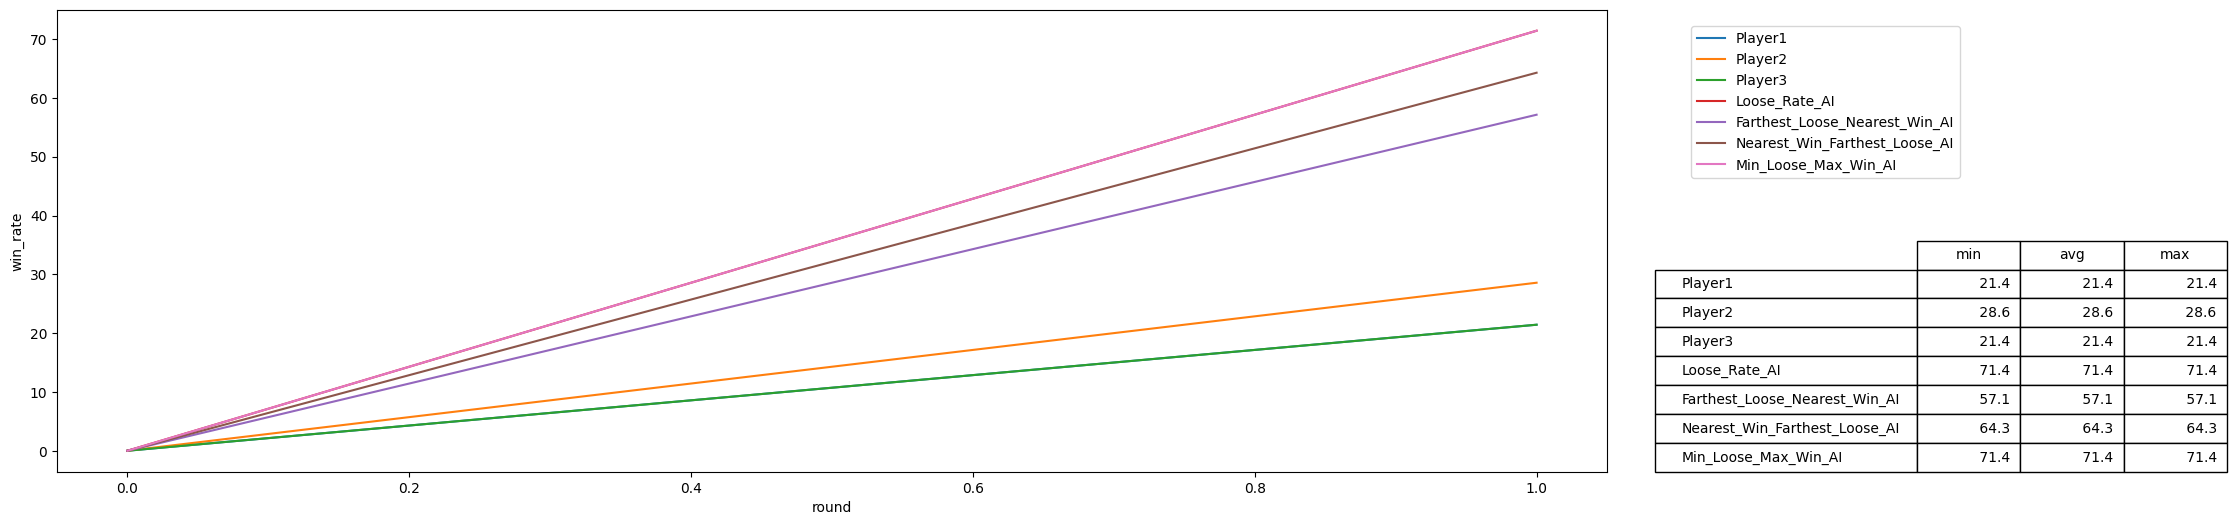

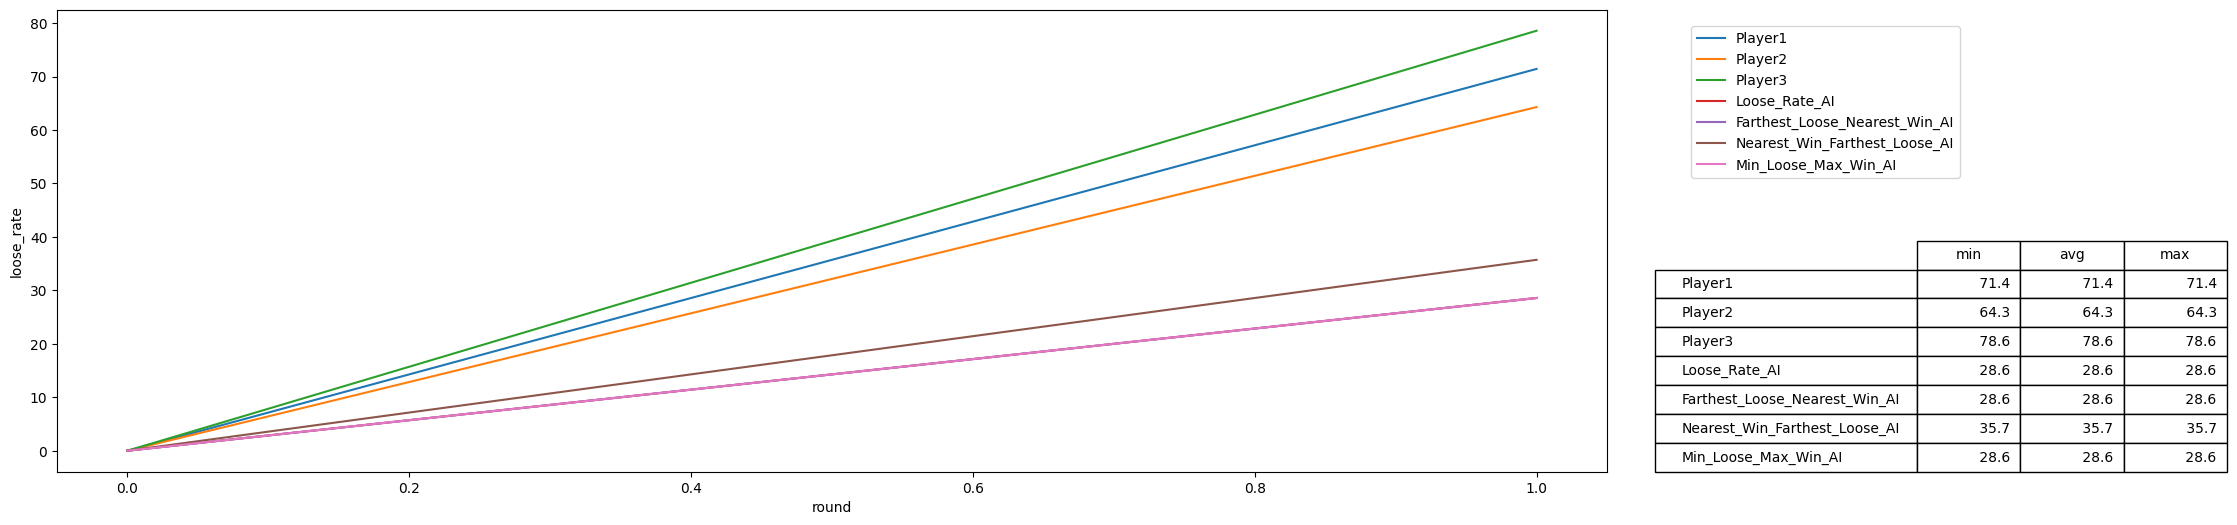

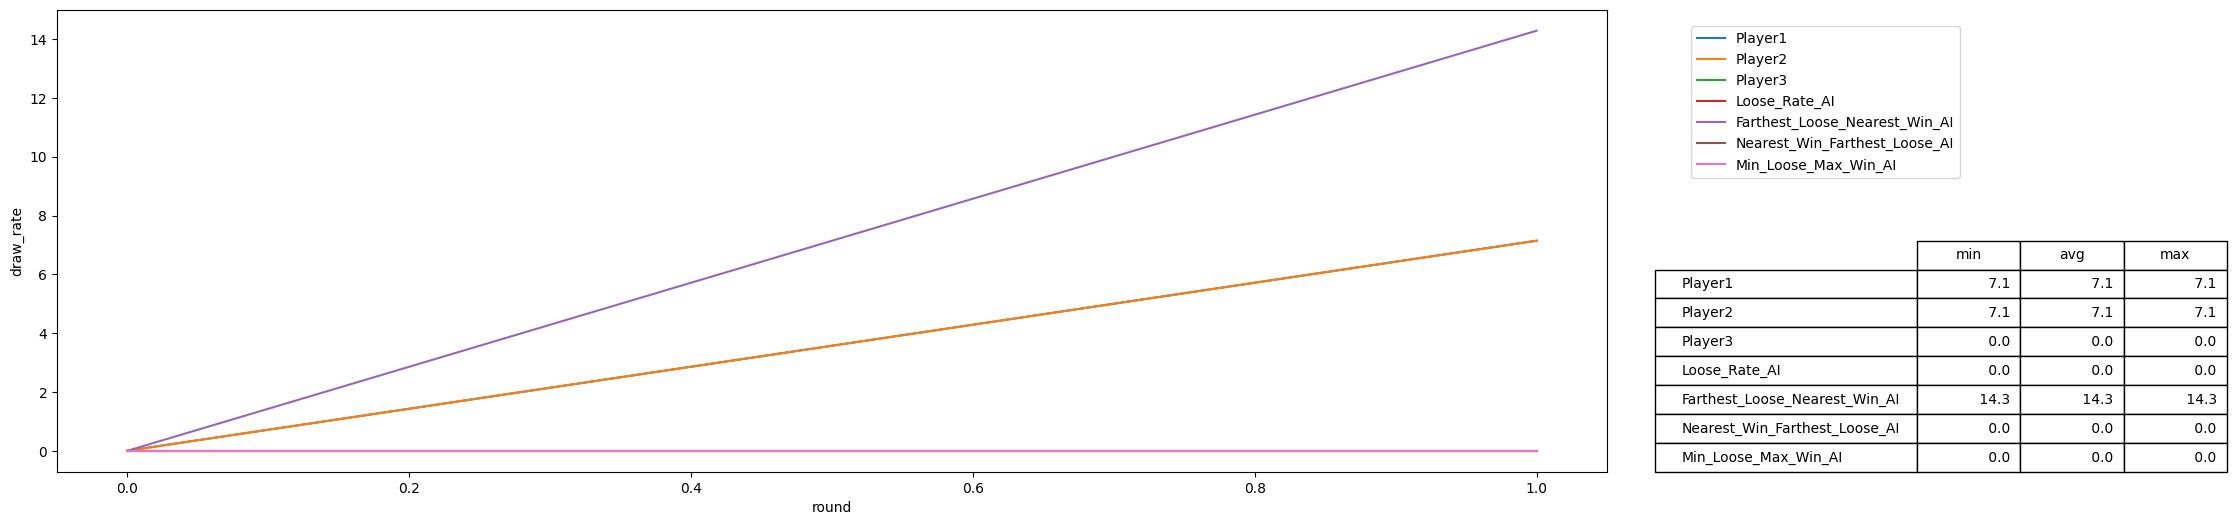

Round 20


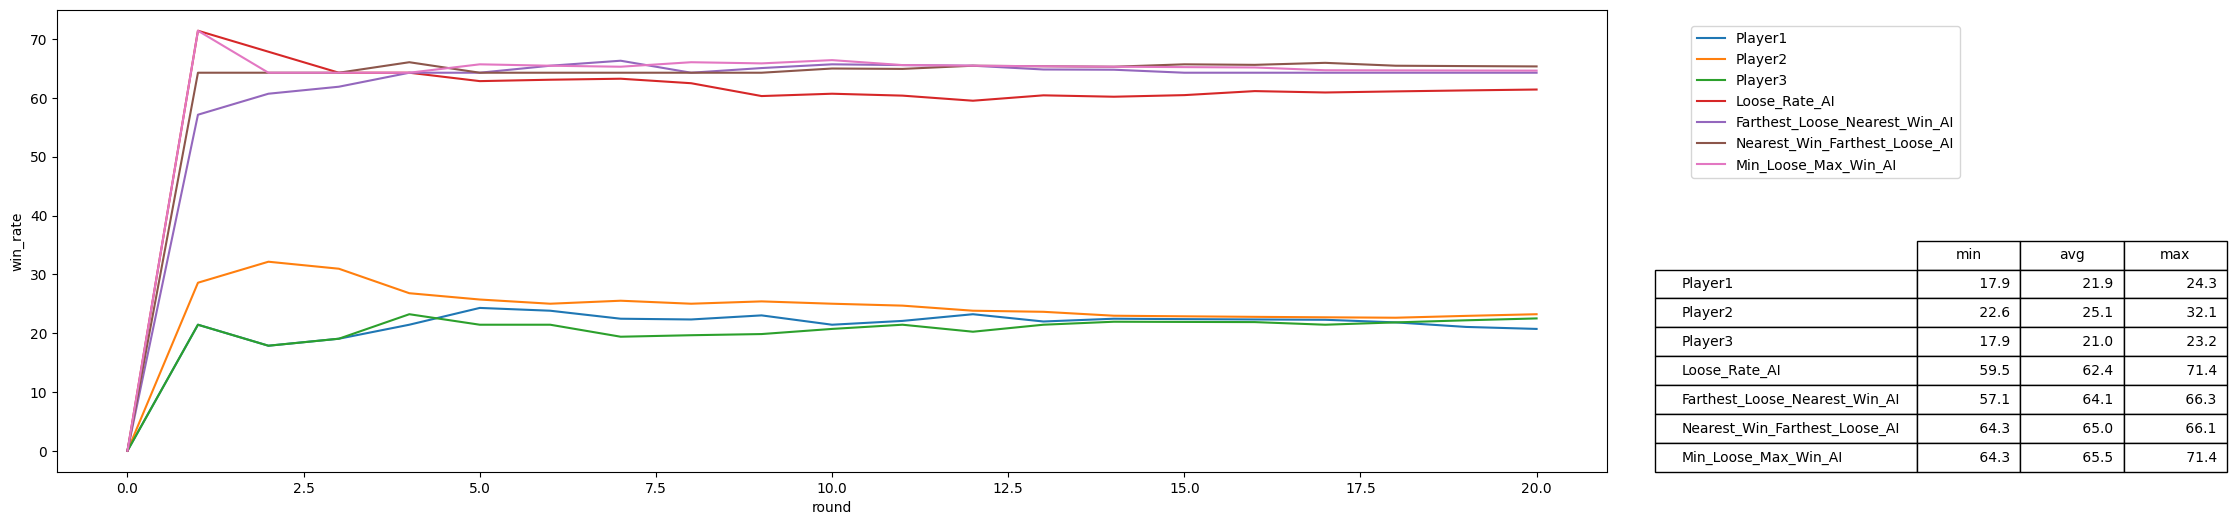

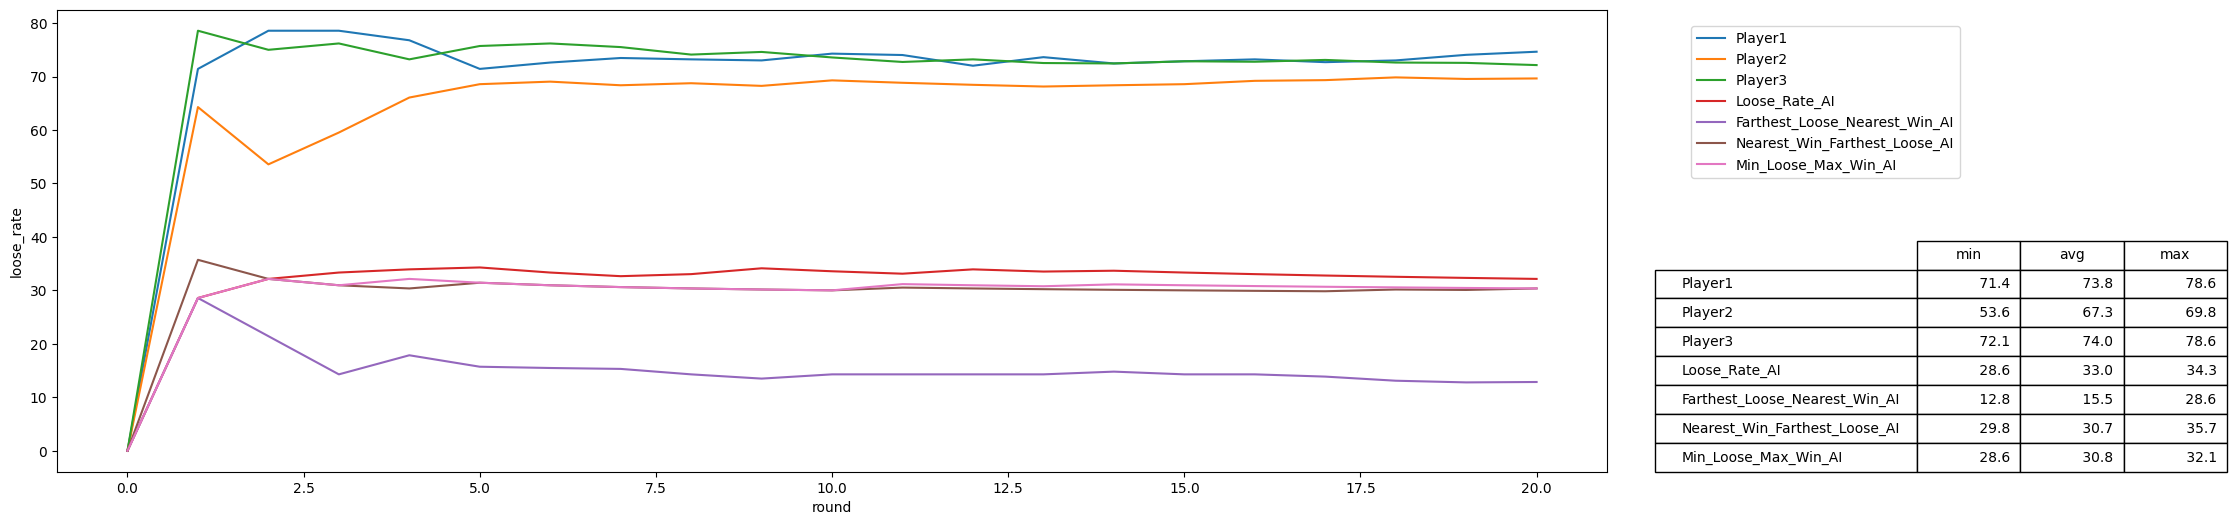

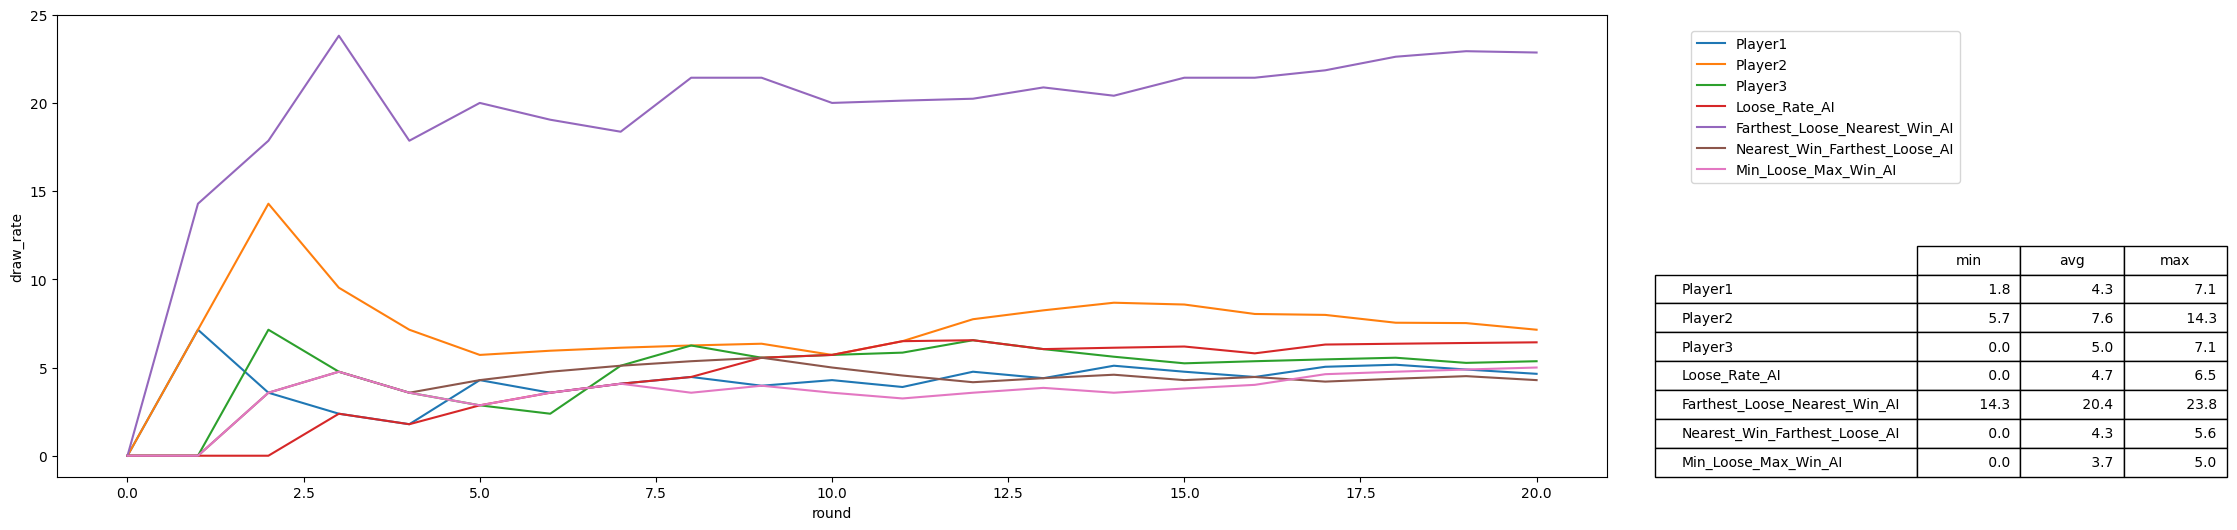

Round 40


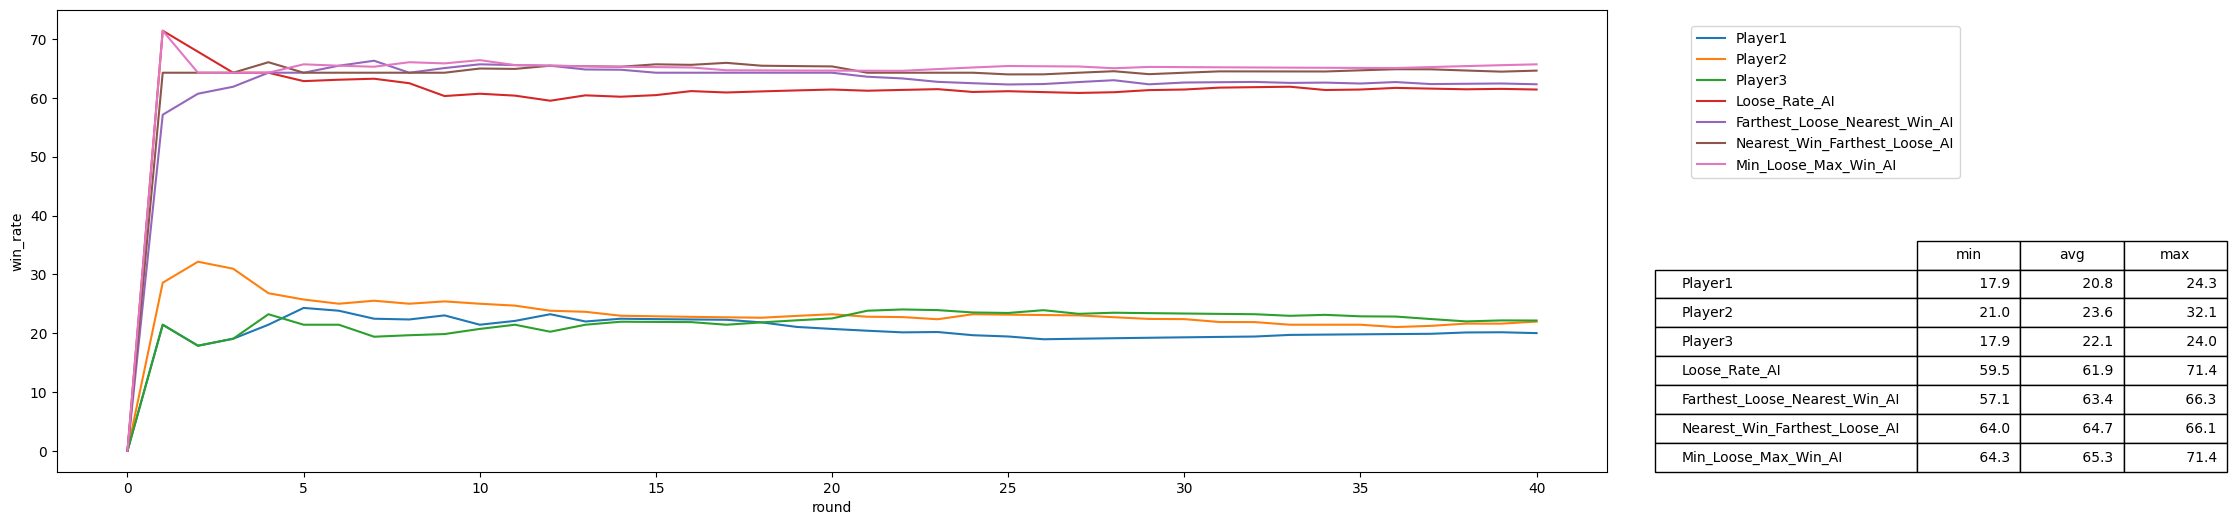

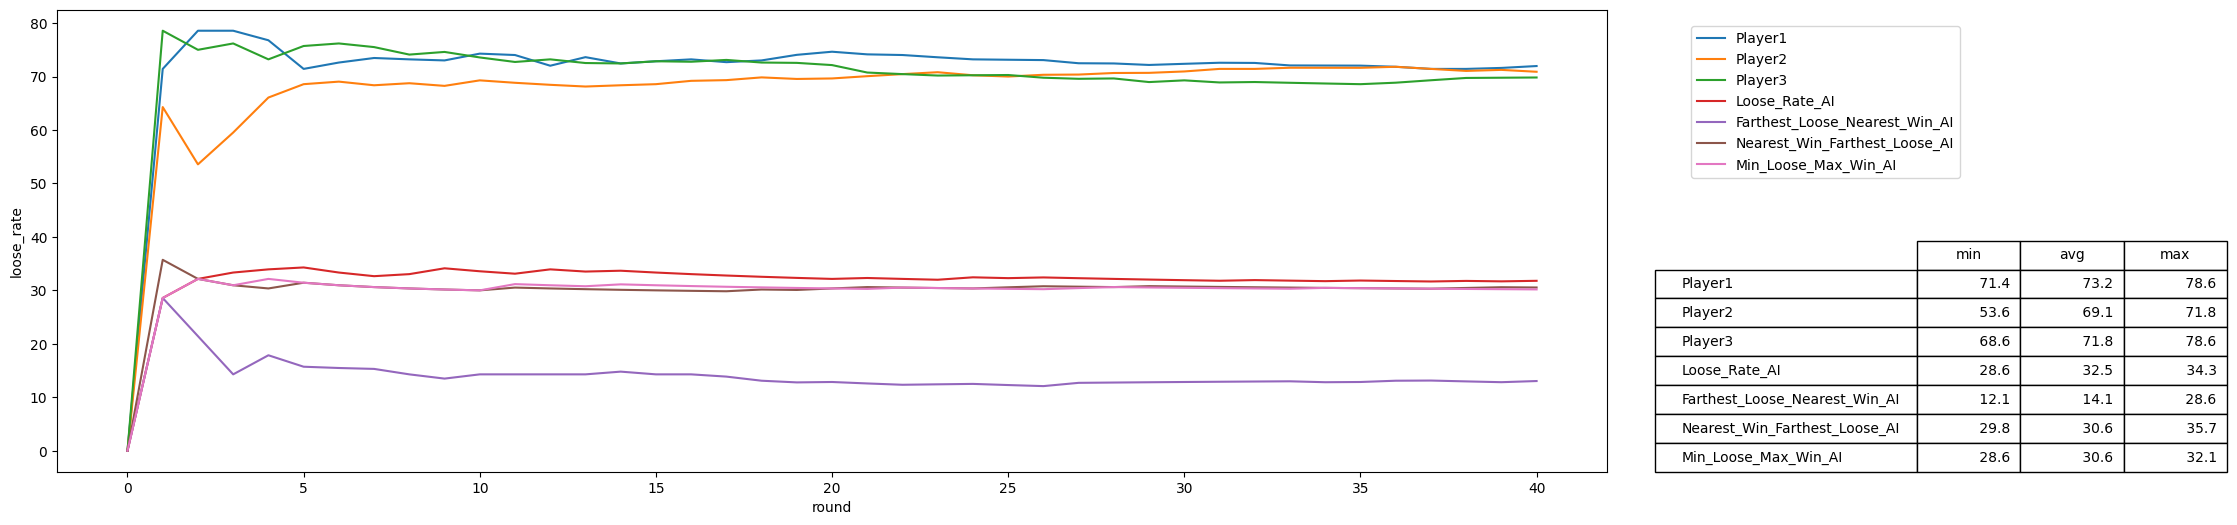

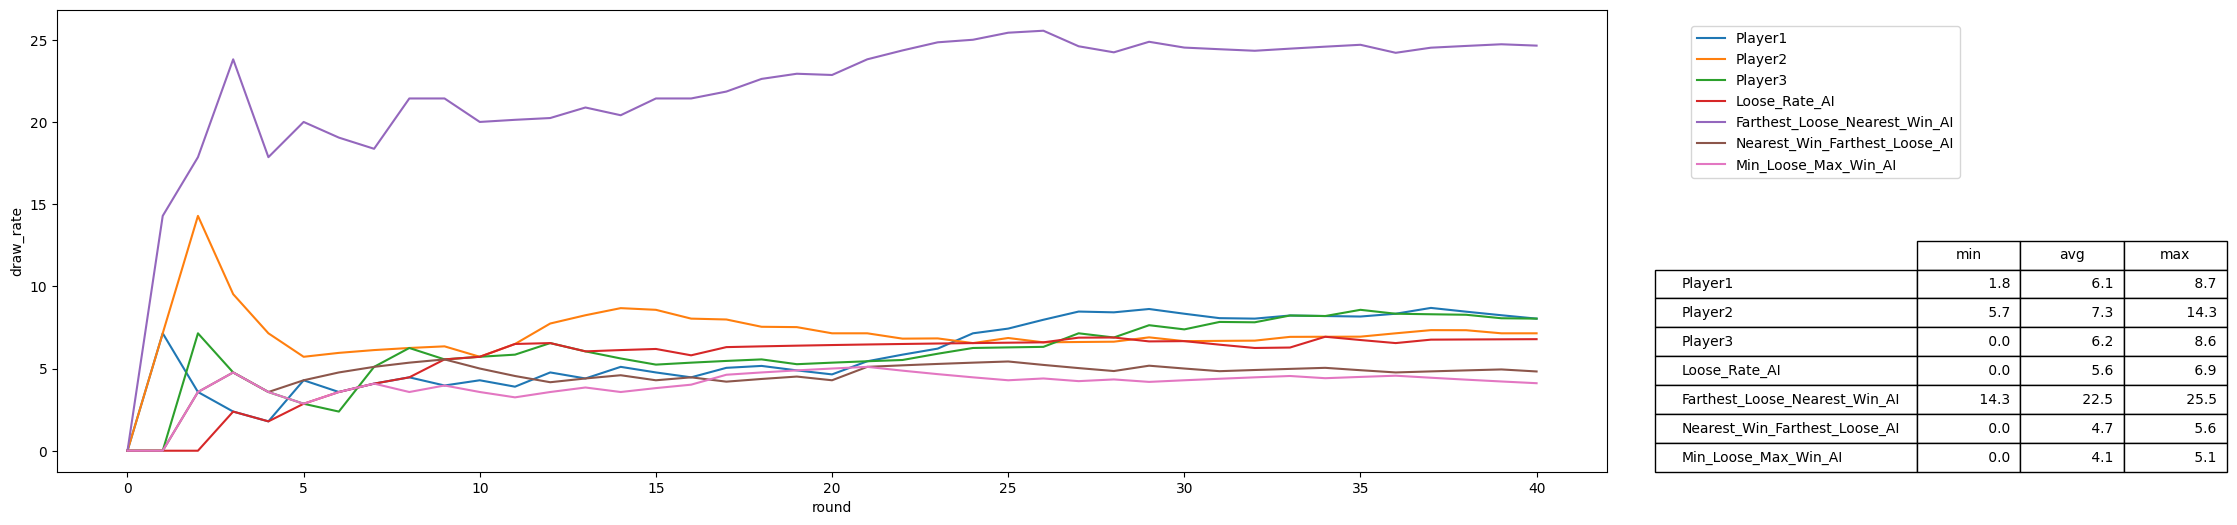

Round 60


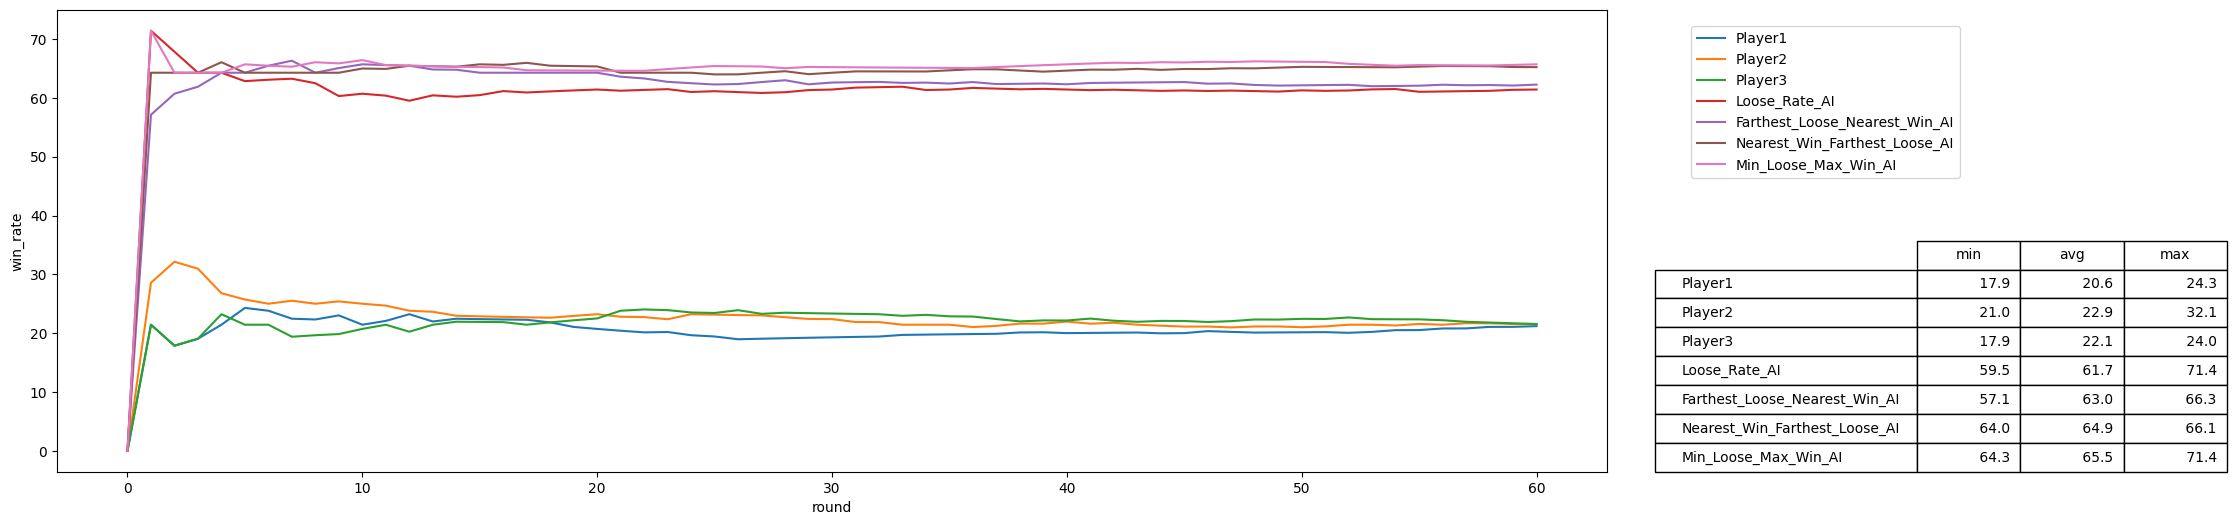

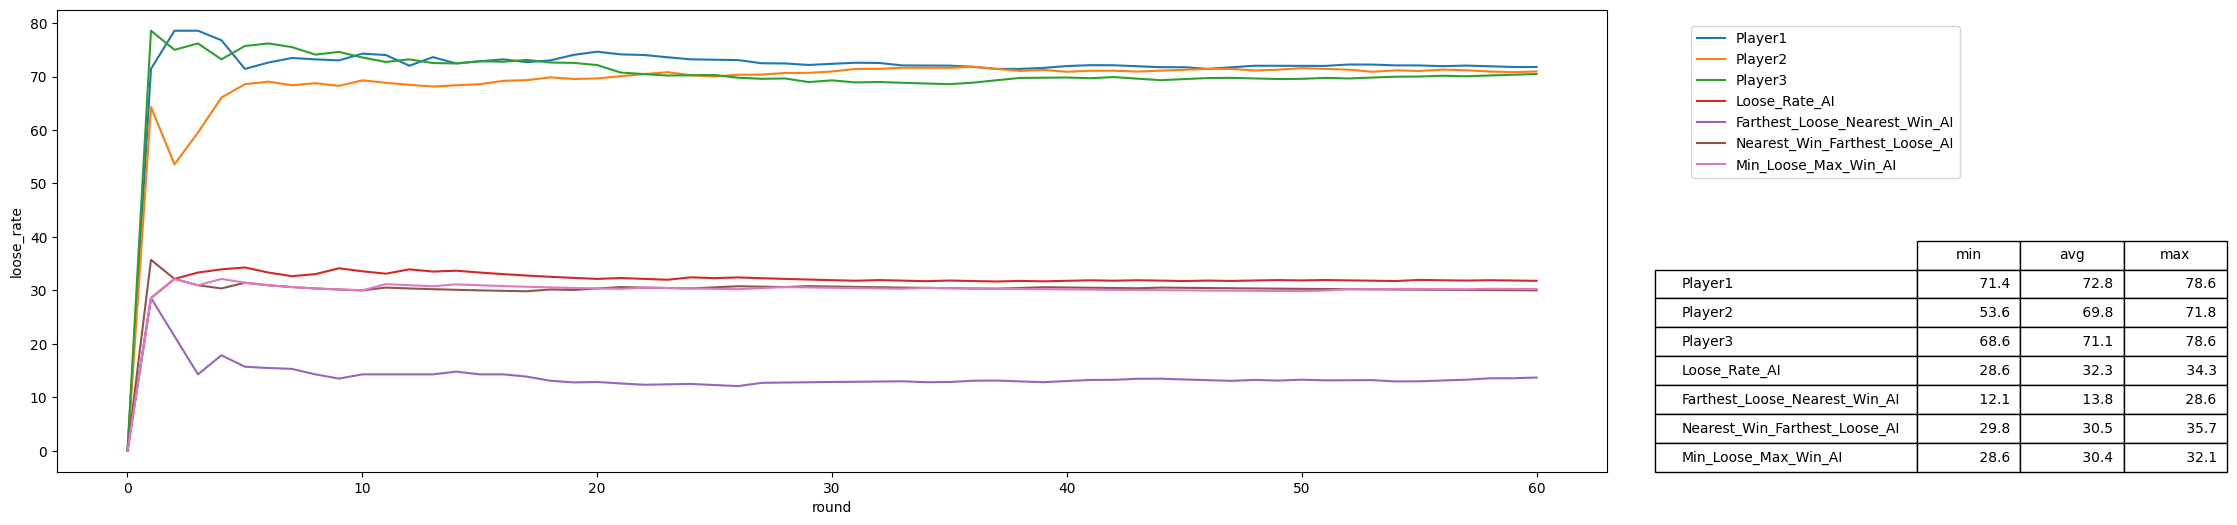

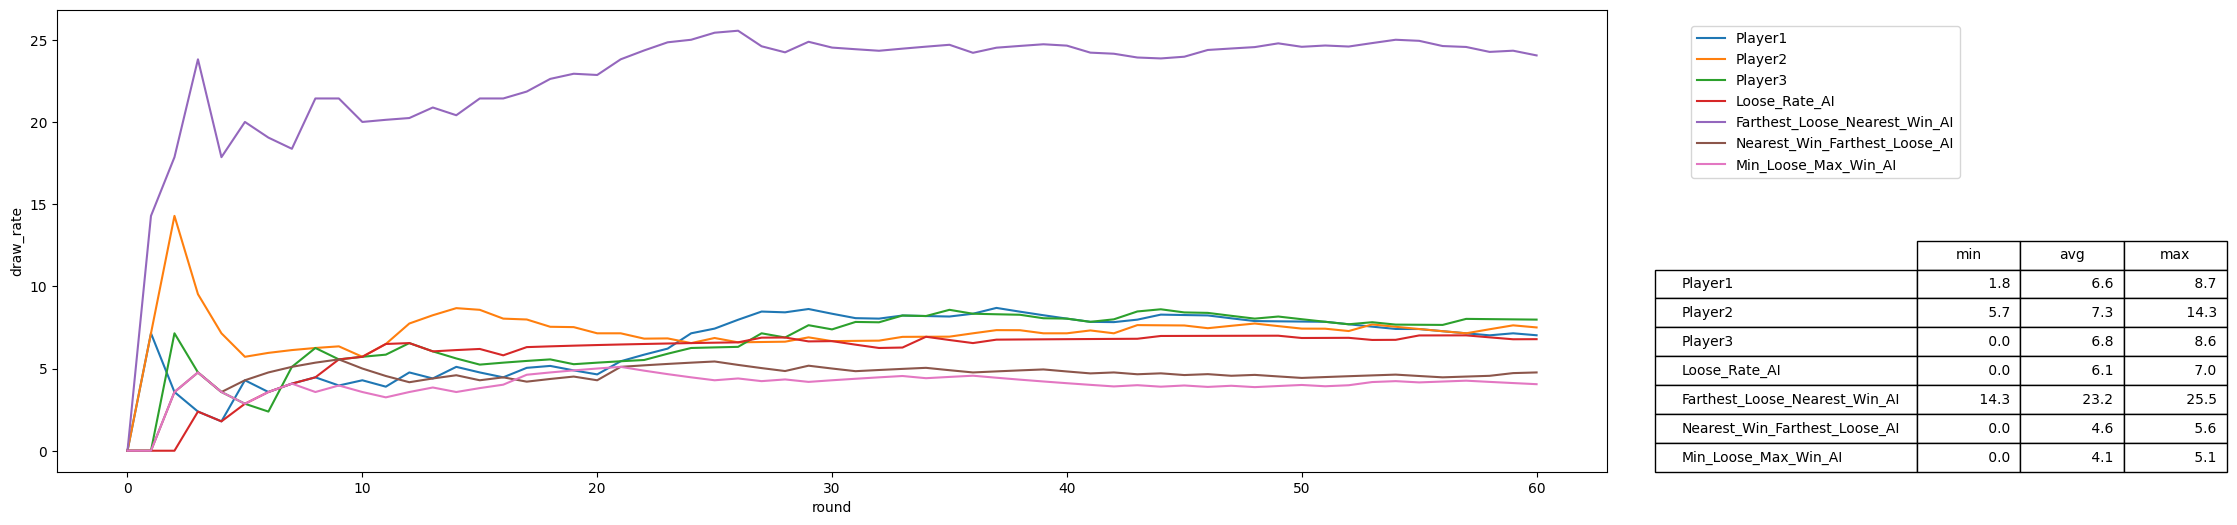

Round 80


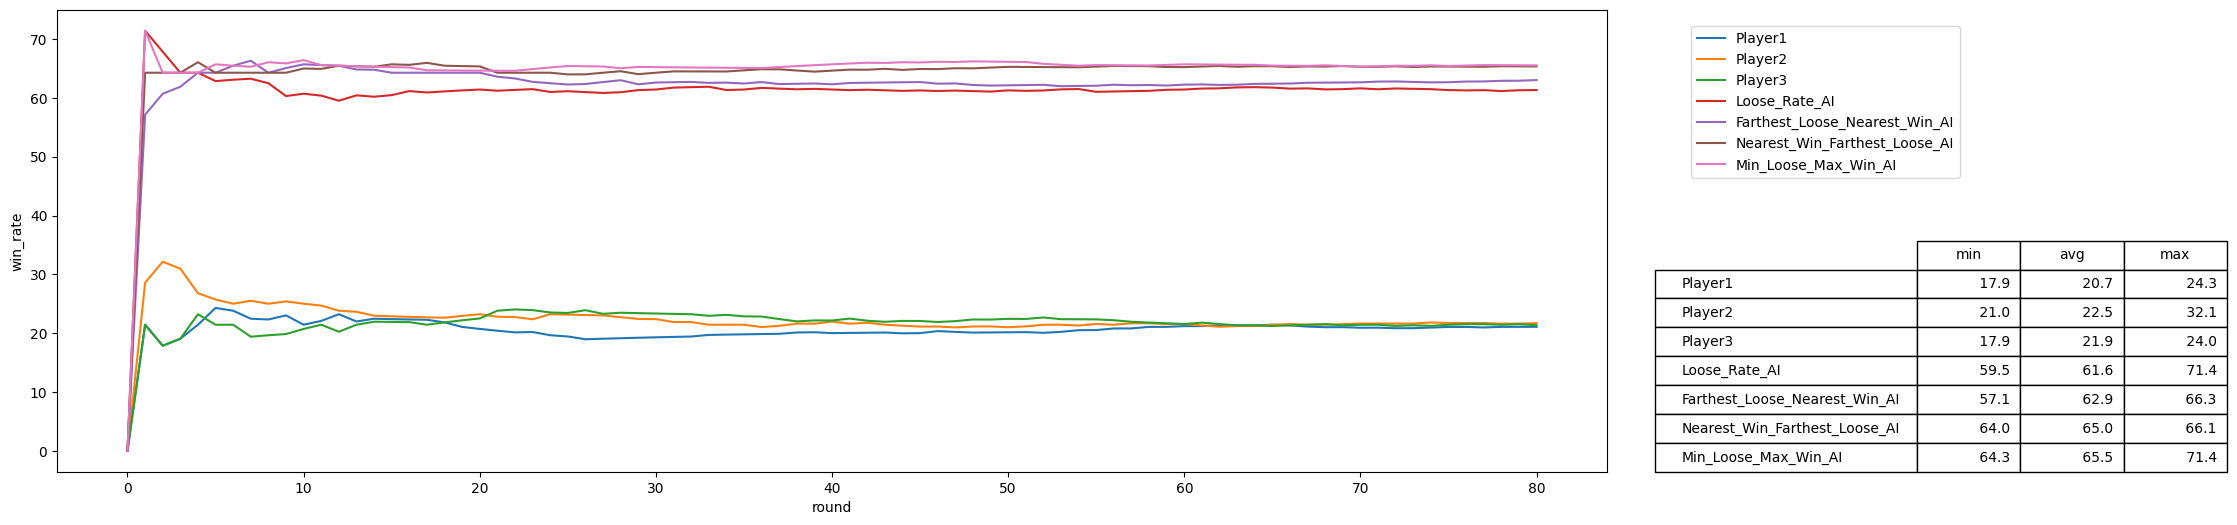

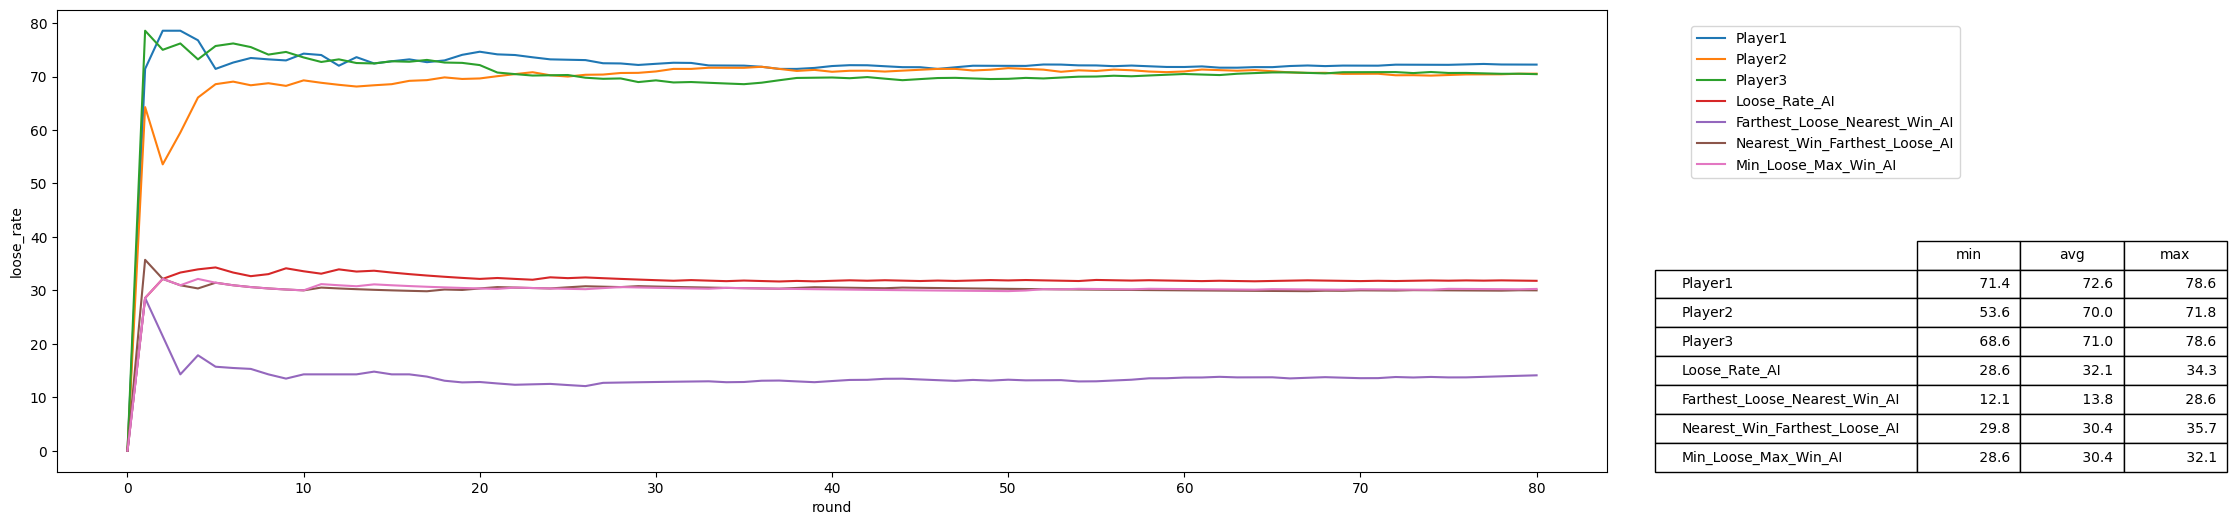

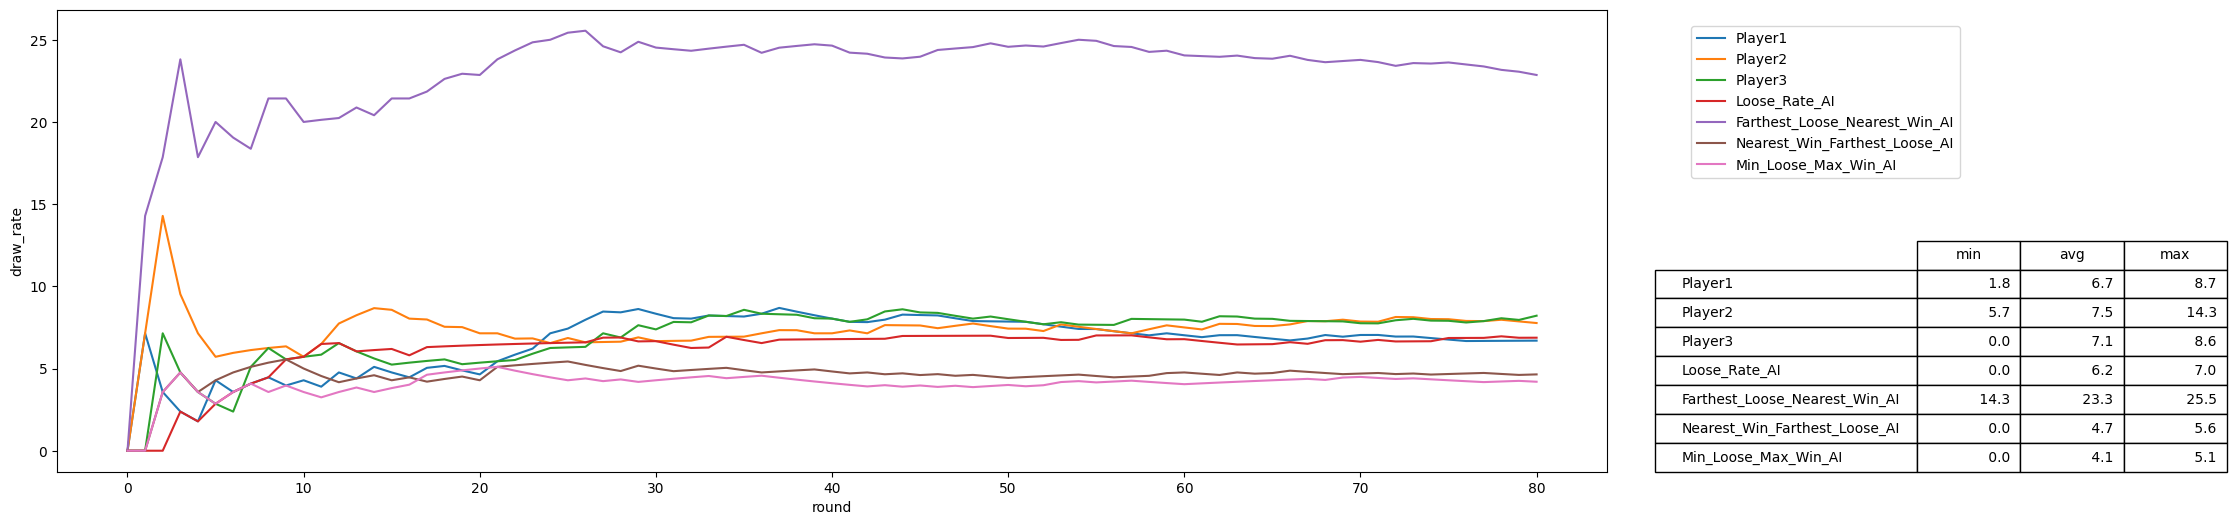

Round 100


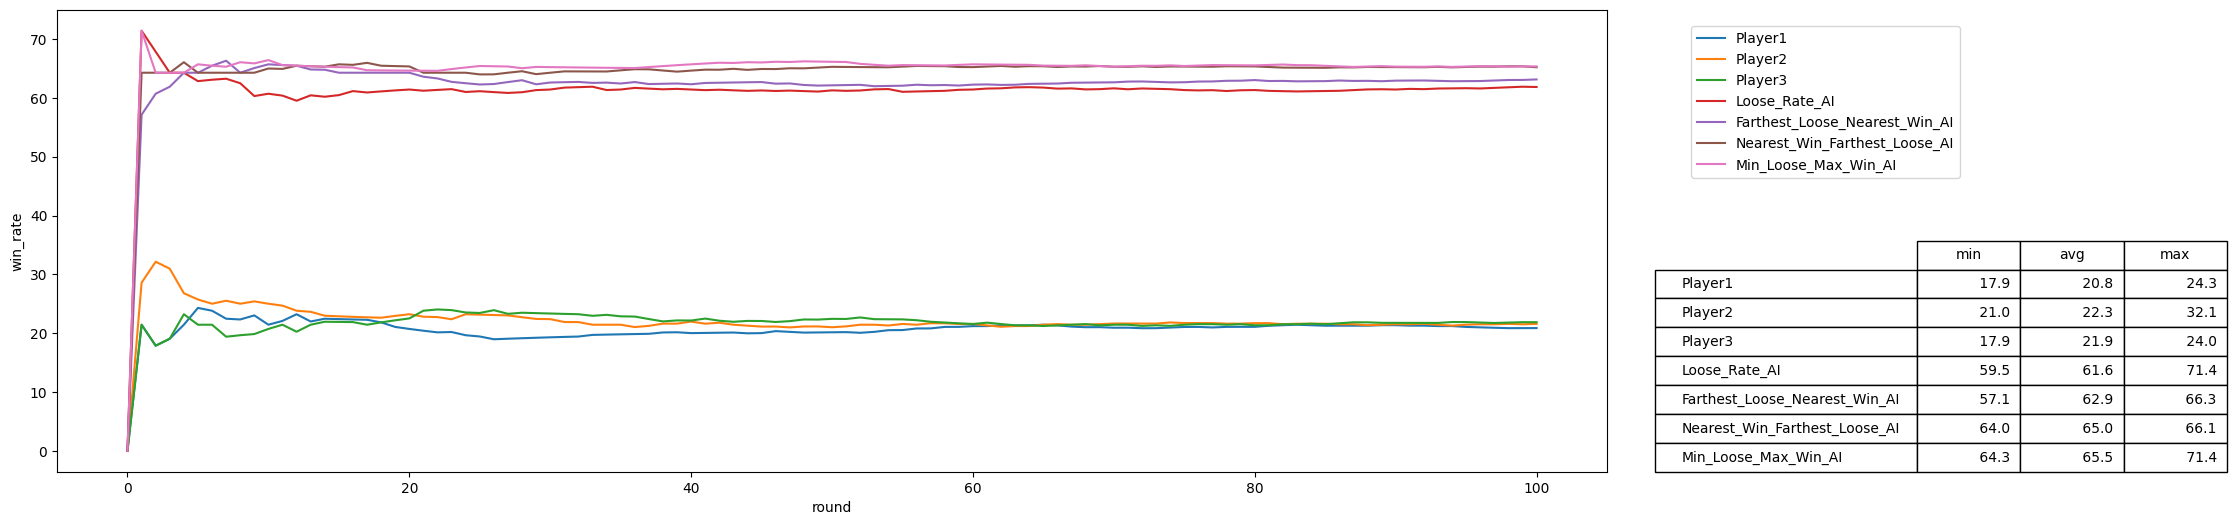

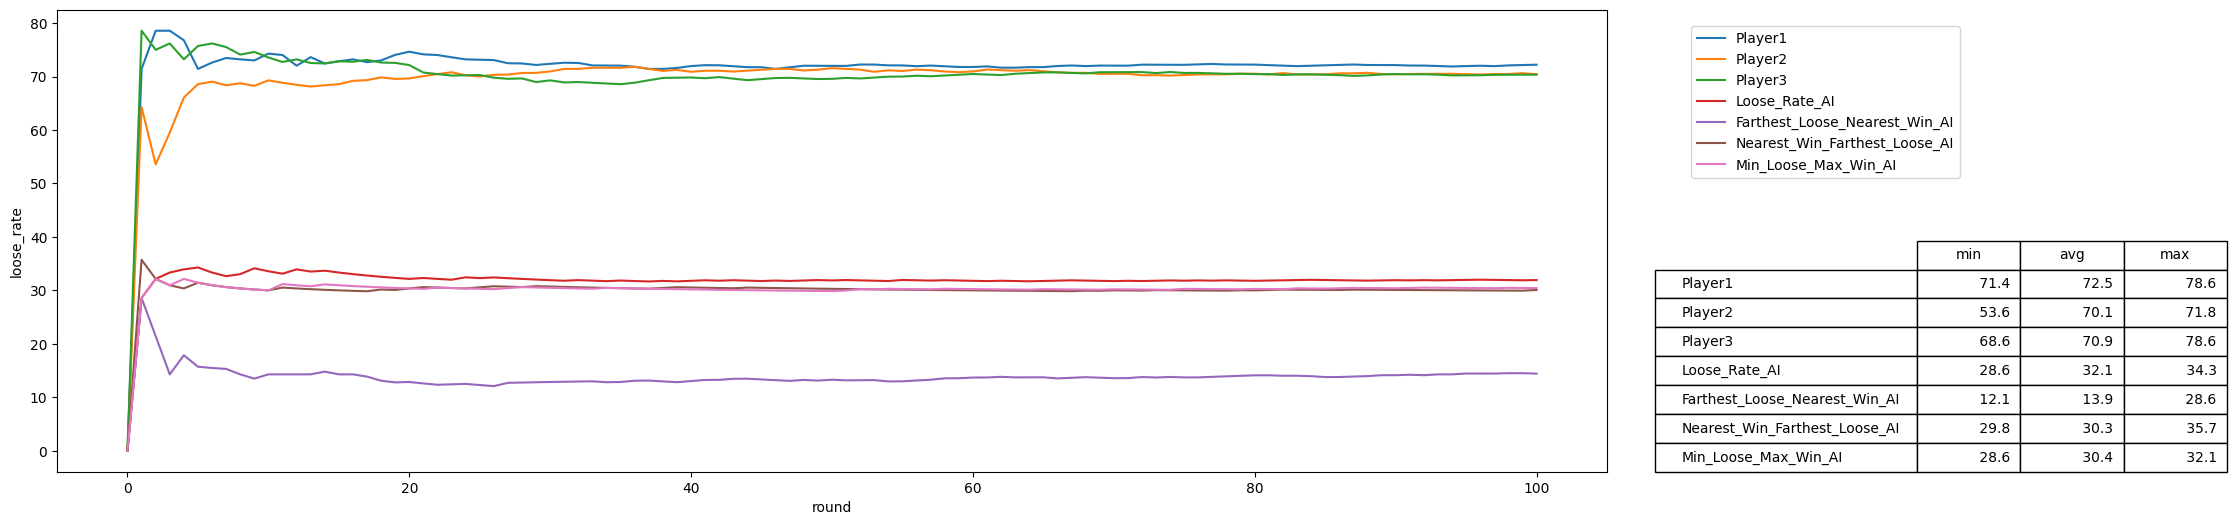

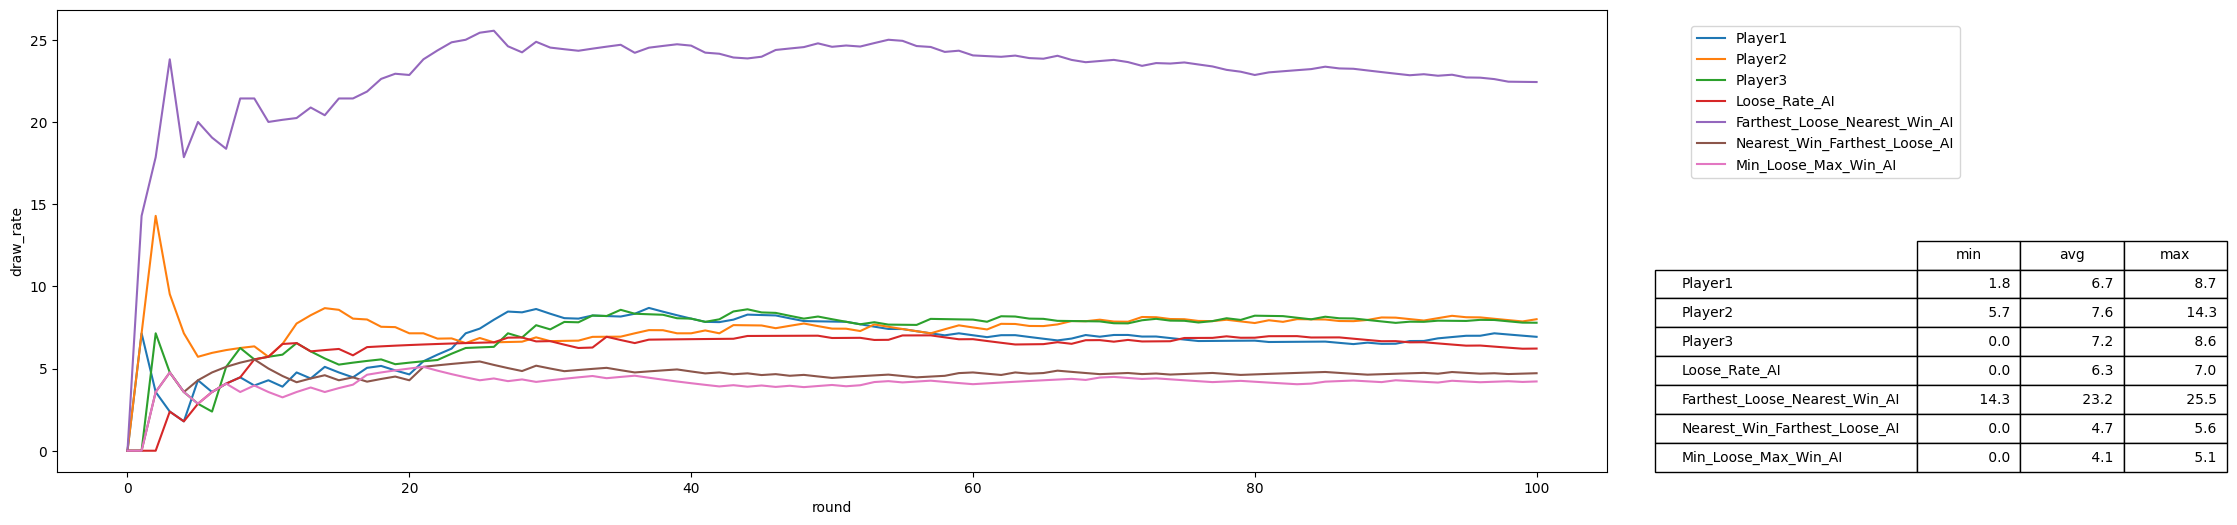

In [386]:
game = Game()
score_board = {}
rounds_score_board = {}

players = [
	Player('Player1', score_board),
	Player('Player2', score_board),
	Player('Player3', score_board),
	# Win_Rate_AI('Win_Rate_AI', score_board),
	Loose_Rate_AI('Loose_Rate_AI', score_board),
	# Nearest_Wins_Distance_AI('Nearest_Wins_Distance_AI', score_board),
	# Nearest_Looses_Distance_AI('Nearest_Looses_Distance_AI', score_board),
	Farthest_Loose_Nearest_Win_AI('Farthest_Loose_Nearest_Win_AI', score_board),
	Nearest_Win_Farthest_Loose_AI('Nearest_Win_Farthest_Loose_AI', score_board),
	# Max_Win_Min_Loose_AI('Max_Win_Min_Loose_AI', score_board),
	Min_Loose_Max_Win_AI('Min_Loose_Max_Win_AI', score_board),
]
rounds_count = 100
for i in range(rounds_count):
	for player_x in players:
		for player_o in players:
			game.play(player_x, player_o)

	for player, player_score in score_board.items():
		if player not in rounds_score_board:
			rounds_score_board.update({player: {
				'total': [0],
				'win_rate': [0],
				'loose_rate': [0],
				'draw_rate': [0],
			}})
		board = rounds_score_board[player]
		games_count = player_score['win_count'] + player_score['loose_count'] + player_score['draw_count']
		board['win_rate'].append(player_score['win_count'] / games_count * 100)
		board['loose_rate'].append(player_score['loose_count'] / games_count * 100)
		board['draw_rate'].append(player_score['draw_count'] / games_count * 100)
		# print(f'{player}: \n' + '\n'.join([f'\t{score}: {value: .1f},' for score, value in board.items()]))
		# print()
	if (i + 1) % (rounds_count // 5) == 0 or i == 0 or i == rounds_count - 1:
		print('Round', i+1)
		for score in ['win_rate', 'loose_rate', 'draw_rate']:
			plt.figure(figsize=(20, 6))
			table_vals = []
			for player, values in rounds_score_board.items():
				plt.plot(values[score], label=player)
				table_vals.append([
					f'{min(values[score][1:]): .1f}',
					f'{sum(values[score][1:]) / len(values[score][1:]): .1f}',
					f'{max(values[score][1:]): .1f}',
				])
			
			the_table = plt.table(
				cellText=table_vals,
				colWidths = [0.1]*3,
				rowLabels=[player for player in rounds_score_board],
				colLabels=['min', 'avg', 'max'],
				bbox=(1.2, 0, .2, .5)
			)
			plt.legend(bbox_to_anchor=(1.05, .8), loc='center left')
			plt.xlabel('round')
			plt.ylabel(score)
			plt.show()